# vertical solar capture rate

This notebook is used to find the optimal solar panel orientation to maximize energy _volume_ vs energy _value_. Conventional wisdom is to point the panel north/south (towards the equator), sloped at an angle equal to the latitude you're at. This maximizes total MWh. However MWh of solar power are not very scarce on a sunny summer day at midday. It is scarce in evenings, and in winter. This means that the spot market price (i.e. the value to society, adjusted downwards by LGC subsidies) is much higher in winter, and in evenings. So why not point the panels more vertically, and more west? This notebook calculates the revenue from doing that in each NEM (Australian) region, for each possible angle.

To run this notebook, install the Python dependencies in `requirements.txt`. Then change `data_dir`, `nemosis_dir` and `results_dir` to suit your needs. (You can probably set `nemosis_dir = data_dir = results_dir`.) This notebook downloads the relevant price data from [`nemweb`](https://www.nemweb.com.au/Data_Archive/Wholesale_Electricity/MMSDM/).


The terms for orientation are:

* Azimuth:
  * horizontal compass orientation.
  * 0=north
  * 90=east

* Zenith
  * up-down
  * Sun:
    * 90 = sunset/sunrise
    * 0 = sun directly overhead (midday, if near the equator)
  * Panel:
    * 90=panel is vertical, facing horizon
    * 0=panel is horizontal, facing straight up

In [1]:
import datetime as dt
import os
import glob

import polars as pl
import astral
from astral.geocoder import database, lookup
import astral.sun
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pytz
from nemosis import dynamic_data_compiler, cache_compiler, static_table
from tqdm import tqdm

In [2]:
data_dir = '/home/matthew/Data/vertical-solar/'
nemosis_dir = '/home/matthew/Data/nemosis/' #os.path.join(data_dir, "nemosis")

results_dir = 'results'

In [3]:
start_time = dt.datetime(2015, 1, 1, 0, 5)
end_time = dt.datetime(2024, 12, 31, 23, 55)

file_dt_fmt = "%Y_%m_%d_%H_%M_%S"

nemosis_dt_fmt = "%Y/%m/%d %H:%M:%S"
aemo_dt_fmt = nemosis_dt_fmt

# number of degrees we check
# e.g. 0, 2, 4, ... 358 degrees
panel_azimuth_step = 2
panel_zenith_step = 2

results_pq_path = os.path.join(results_dir, f"results_full_{start_time.strftime(file_dt_fmt)}_to_{end_time.strftime(file_dt_fmt)}_{panel_azimuth_step=}_{panel_zenith_step}.parquet")

In [4]:
# map NEM regions to Astral cities
region_cities = {
   'VIC1': 'Melbourne',
   'TAS1': 'Hobart',
   'NSW1': 'Sydney', 
   'QLD1': 'Brisbane',
   'SA1': 'Adelaide'
}


In [5]:
intervals_per_h = 12

## Get Price Data

In [6]:
os.makedirs(data_dir, exist_ok=True)

In [7]:
# cache file locally
# so when I'm on the train with bad wifi, it doesn't try to re-crawl nemweb

def escape_date(s):
    return s.split(' ')[0].replace('/', '_')

tables = ["DISPATCHPRICE", "ROOFTOP_PV_ACTUAL", "DISPATCH_UNIT_SCADA"]

for table in tables:

    print(f"Downloading {table} to {nemosis_dir}")
    cache_compiler(
        start_time.strftime(nemosis_dt_fmt),
        end_time.strftime(nemosis_dt_fmt),
        table, 
        nemosis_dir,
        fformat='parquet'
    )

INFO: Caching data for table DISPATCHPRICE
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRICE in date range already compiled in /home/matthew/Data/nemosis/.
INFO: Cache for DISPATCHPRI

In [8]:
(
    pl.scan_parquet(os.path.join(nemosis_dir, "*_DISPATCHPRICE_*.parquet"))
    .with_columns(
        pl.col("SETTLEMENTDATE").str.strptime(pl.Datetime("ms"), aemo_dt_fmt)
    )
    .head().collect()
)
    

SETTLEMENTDATE,REGIONID,INTERVENTION,RRP,RAISE6SECRRP,RAISE60SECRRP,RAISE5MINRRP,RAISEREGRRP,LOWER6SECRRP,LOWER60SECRRP,LOWER5MINRRP,LOWERREGRRP,PRICE_STATUS
datetime[ms],str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
2013-12-01 00:05:00,"""NSW1""",0,49.88993,0.2,0.17,0.59,0.59,0.2,0.17,0.27,0.27,"""FIRM"""
2013-12-01 00:05:00,"""QLD1""",0,49.18127,0.2,0.17,0.59,0.59,0.2,0.17,0.27,0.27,"""FIRM"""
2013-12-01 00:05:00,"""SA1""",0,44.31364,0.2,0.17,0.59,0.59,0.2,0.17,0.27,0.27,"""FIRM"""
2013-12-01 00:05:00,"""TAS1""",0,42.20142,0.2,0.17,0.59,0.59,0.2,0.17,0.27,0.27,"""FIRM"""
2013-12-01 00:05:00,"""VIC1""",0,45.13013,0.2,0.17,0.59,0.59,0.2,0.17,0.27,0.27,"""FIRM"""


In [9]:
# nem data is in 5 minute intervals
interval_min = 5
interval_sec = interval_min * 60

# polars timedelta expression for half an interval
half_offset = f"-{interval_sec//2}s"

price_lf = (
    pl.scan_parquet(os.path.join(nemosis_dir, "*_DISPATCHPRICE_*.parquet"))
    .with_columns(
        pl.col("SETTLEMENTDATE").str.strptime(pl.Datetime('ms'), aemo_dt_fmt)
    )
    .filter(pl.col("SETTLEMENTDATE").is_between(start_time, end_time))
    .filter(pl.col("INTERVENTION") == 0)
    .with_columns(
        pl.col("SETTLEMENTDATE").dt.replace_time_zone(time_zone="Australia/Brisbane")
    )
    .select(
        "REGIONID",
        pl.col("SETTLEMENTDATE").alias("INTERVAL_END"),
        pl.col("SETTLEMENTDATE").dt.offset_by(half_offset).alias("INTERVAL_MID"),
        pl.col("RRP").alias("PRICE")
    )
    #.with_columns(
    #    pl.col("REGIONID")
    #    .replace_strict(region_cities)
    #    .alias("CITY")
    #)
)
price_lf.head().collect()

REGIONID,INTERVAL_END,INTERVAL_MID,PRICE
str,"datetime[ms, Australia/Brisbane]","datetime[ms, Australia/Brisbane]",f64
"""NSW1""",2015-01-01 00:05:00 AEST,2015-01-01 00:02:30 AEST,46.81124
"""QLD1""",2015-01-01 00:05:00 AEST,2015-01-01 00:02:30 AEST,44.30678
"""SA1""",2015-01-01 00:05:00 AEST,2015-01-01 00:02:30 AEST,45.99022
"""TAS1""",2015-01-01 00:05:00 AEST,2015-01-01 00:02:30 AEST,38.86599
"""VIC1""",2015-01-01 00:05:00 AEST,2015-01-01 00:02:30 AEST,19.59986


## Get Sun Data

In [10]:
observers = {}

for (region, city) in region_cities.items():
    observers[region] = lookup(city, database()).observer

In [11]:
brisbane_tz = pytz.timezone('Australia/Brisbane')

def get_sun_angle(region, time):
    observer = observers[region]

    assert time.tzinfo is not None, "time zone not set up right"

    zenith = astral.sun.zenith(observer, time)
    azimuth = astral.sun.azimuth(observer, time)

    return (zenith, azimuth)



In [12]:
data = []
price_df = price_lf.collect()
for row in tqdm(price_df.iter_rows(named=True), total = price_df.height, leave=False):
    region = row['REGIONID']
    time = row['INTERVAL_MID']
    (zenith, azimuth) = get_sun_angle(region, time)
    assert zenith >= 0, f"Negative zenith: {zenith=}"
    if zenith <= 90: # sun is up
        data.append({
            'REGIONID': region,
            'TIME': time,
            #'PRICE': row['PRICE'],
            'SUN': {
                'ZENITH': zenith,
                'AZIMUTH': azimuth
            }
        })

sun_lf = (
    pl.DataFrame(data)
    .lazy()
    .with_columns(
        pl.col("TIME").dt.cast_time_unit('ms')
    )
)
sun_lf.head().collect()

REGIONID,TIME,SUN
str,"datetime[ms, Australia/Brisbane]",struct[2]
"""TAS1""",2015-01-01 04:37:30 AEST,"{89.931272,122.853592}"
"""TAS1""",2015-01-01 04:42:30 AEST,"{89.275012,122.002141}"
"""TAS1""",2015-01-01 04:47:30 AEST,"{88.581277,121.157206}"
"""NSW1""",2015-01-01 04:52:30 AEST,"{89.407036,118.050525}"
"""TAS1""",2015-01-01 04:52:30 AEST,"{87.858116,120.318535}"


## Calculations

In [6]:

# takes in a azimuth and zenith column
# returns a struct column, of an xyz vector
def az_zen_to_xyz(v):
    return pl.struct(
        # NORTH
        X = v.struct.field("ZENITH").radians().sin() *
            v.struct.field("AZIMUTH").radians().cos(),
        # EAST
        Y = v.struct.field("ZENITH").radians().sin() *
            v.struct.field("AZIMUTH").radians().sin(),
        # up
        Z = v.struct.field("ZENITH").radians().cos()
    )


# takes in two struct columns (x, y, z)
# returns cos(theta) of the angle between them
def dot_product(a, b):
    return (
        a.struct.field("X") * b.struct.field("X") +
        a.struct.field("Y") * b.struct.field("Y") +
        a.struct.field("Z") * b.struct.field("Z")
    )

# returns an angle between to cartesian vectors
def angle_between(a, b):
    return dot_product(a, b).arccos().degrees()

In [14]:
# # range of orientations to test
# panel_azimuth_step = 10
# panel_azimuths = pl.int_range(0, 360, panel_azimuth_step, eager=False)

# panel_zenith_step = 10
# panel_zeniths = pl.int_range(0, 90+1, panel_zenith_step, eager=False)

# power_df = (
#     sun_lf
#     .lazy()
#     .join(
#         #pl.LazyFrame().select(PANEL_AZIMUTH=panel_azimuths),
#         pl.LazyFrame({"PANEL_AZIMUTH": panel_azimuths}),
#         how='cross'
#     )
#     .join(
#         pl.LazyFrame().select(PANEL_ZENITH=panel_zeniths),
#         how='cross'
#     )
#     .with_columns(
#         pl.struct(AZIMUTH="PANEL_AZIMUTH", ZENITH="PANEL_ZENITH").alias("PANEL")
#     )
#     .with_columns(
#         pl.col("PANEL").pipe(az_zen_to_xyz).alias("PANEL_XYZ"),
#         pl.col("SUN").pipe(az_zen_to_xyz).alias("SUN_XYZ"),
#     )
#     .with_columns(
#         pl.map_batches(
#             ["PANEL_XYZ", "SUN_XYZ"],
#             lambda row: dot_product(row[0], row[1]),
#             return_dtype=pl.Float64
#         )
#         .alias("COS_THETA")
#     )
#     .filter(
#         pl.col("COS_THETA") > 0
#     )
#     .rename({"COS_THETA": "POWER"})
#     .filter(
#         pl.col("SUN").struct.field("ZENITH") <= 90
#     )
# )

# power_df.head().collect()

In [15]:
num_intervals = (
    price_lf
    .select(pl.col("INTERVAL_MID").n_unique())
    .collect()
    .item()
)
num_hours = num_intervals / intervals_per_h

In [16]:
# Do each separate panel configuration in a loop
# collecting as we go
# otherwise we run out of memory (surprisingly)


results = []
for panel_azimuth in tqdm(range(0,360,panel_azimuth_step), leave=False):
    for panel_zenith in range(0,90+1,panel_zenith_step):
        df = (
            sun_lf
            .with_columns(
                pl.struct(AZIMUTH=pl.lit(panel_azimuth), 
                          ZENITH=pl.lit(panel_zenith)
                ).alias("PANEL")
            )
            .with_columns(
                pl.col("PANEL").pipe(az_zen_to_xyz).alias("PANEL_XYZ"),
                pl.col("SUN").pipe(az_zen_to_xyz).alias("SUN_XYZ"),
            )
            .with_columns(
                pl.map_batches(
                    ["PANEL_XYZ", "SUN_XYZ"],
                    lambda row: dot_product(row[0], row[1]),
                    return_dtype=pl.Float64
                )
                .alias("COS_THETA")
            )
            .filter(
                pl.col("COS_THETA") >= 0
            )
            .rename({"COS_THETA": "POWER"})
            .filter(
                pl.col("SUN").struct.field("ZENITH") <= 90
            )
            .rename({"TIME": "INTERVAL_MID"})
            .join(
                price_lf,
                on=["REGIONID", "INTERVAL_MID"],
                how='right'
            )
            .with_columns(
                pl.col("POWER").fill_null(strategy='zero')
            )
            .with_columns(
                (pl.col("POWER") / intervals_per_h).alias("ENERGY")
            )
            .with_columns(
                (pl.col("PRICE") * pl.col("ENERGY")).alias("REVENUE")
            )
            .group_by("REGIONID", pl.col("INTERVAL_MID").dt.year().alias("YEAR"))
            .agg(
                pl.col("REVENUE").sum(),
                pl.col("ENERGY").sum()
                    
            )
            .with_columns(
                # note that since we filtered some rows
                # we can't just do mean of POWER
                (pl.col("ENERGY") / num_hours).alias("POWER_AVG"),
                    
                (pl.col("REVENUE") / pl.col("ENERGY")).alias("CAPTURE_PRICE")
            )
            .with_columns(
                PANEL=pl.struct(
                          AZIMUTH=pl.lit(panel_azimuth), 
                          ZENITH=pl.lit(panel_zenith)),
                #PANEL_AZIMUTH=pl.lit(panel_azimuth),
                #PANEL_ZENITH=pl.lit(panel_zenith)
            )
            .collect()
        )
        results.append(df.lazy())

        null_rows = (
            df
            .filter(pl.col("PANEL").is_null())
        )
        assert null_rows.is_empty(), f"null panel orientation? {panel_azimuth=} {panel_zenith=}"

        

results_df = pl.concat(results, how='vertical').collect()
results_df.head()

REGIONID,YEAR,REVENUE,ENERGY,POWER_AVG,CAPTURE_PRICE,PANEL
str,i32,f64,f64,f64,f64,struct[2]
"""TAS1""",2016,208711.656221,2124.543683,0.025292,98.238345,"{0,0}"
"""TAS1""",2015,108184.158227,2019.190037,0.024038,53.577997,"{0,0}"
"""QLD1""",2016,182985.014205,2526.666759,0.030079,72.421507,"{0,0}"
"""TAS1""",2021,60786.183128,2019.206657,0.024038,30.103993,"{0,0}"
"""VIC1""",2015,83464.323039,2155.633185,0.025662,38.719168,"{0,0}"


In [17]:
os.makedirs(results_dir, exist_ok=True)
results_df.write_parquet(results_pq_path)

## Graph

In [34]:
# can skip straight to here and not re-run previous slow computations
results_df = pl.read_parquet(results_pq_path)

In [35]:
plot_all_years_df = (
    results_df
    .with_columns(
        PANEL_AZIMUTH=pl.col("PANEL").struct.field("AZIMUTH"),
        PANEL_ZENITH=pl.col("PANEL").struct.field("ZENITH"),
    )
    # shift the starting angle, so the boring part of the plot as at the left/right wraparound
    .with_columns(
        PANEL_AZIMUTH = pl.col("PANEL_AZIMUTH") + pl.when(pl.col("PANEL_AZIMUTH") >= 180).then(pl.lit(-360)).otherwise(pl.lit(0))
    )
    .sort("REGIONID", "PANEL_AZIMUTH", "PANEL_ZENITH")
)

In [36]:
# for the heatmap colours, only show the last year
plot_last_year_df = (
    plot_all_years_df 
    .filter(pl.col("YEAR") == pl.col("YEAR").max())
    .sort("REGIONID")
)

heat_colours_df = plot_last_year_df

In [37]:
# find the setup that gives the maximum energy volume, capture price and revenue
cols = ["POWER_AVG", "CAPTURE_PRICE", "REVENUE"]
peaks = []
for col in cols:
    peaks.append(
        results_df
        .sort(col, descending=True)
        .group_by("REGIONID", "YEAR")
        .first()
        .select(
            "REGIONID",
            "YEAR",
            "PANEL",
            pl.col("PANEL").struct.field("AZIMUTH").alias("PANEL_AZIMUTH"),
            pl.col("PANEL").struct.field("ZENITH").alias("PANEL_ZENITH"),
            pl.lit(col).alias("MAX_OF"),
            *cols
        )
        # shift the starting angle, so the boring part of the plot is at the left/right wraparound
        .with_columns(
            PANEL_AZIMUTH = pl.col("PANEL_AZIMUTH") + pl.when(pl.col("PANEL_AZIMUTH") >= 180).then(pl.lit(-360)).otherwise(pl.lit(0))
        )
    )
    
peaks_all_years = (
    pl.concat(peaks, how='vertical')
    .sort("REGIONID", "YEAR")
    .with_columns(
        pl.when(pl.col("YEAR") == pl.col("YEAR").min())
        .then(pl.col("YEAR").cast(pl.String()))
        .when(pl.col("YEAR") == pl.col("YEAR").max())
        .then(pl.col("YEAR").cast(pl.String()))
        .otherwise(None)
        .alias("YEAR_FIRST_LAST_TEXT"),
        (pl.col("YEAR") - pl.col("YEAR").min() + 1).alias("YEAR_RELATIVE")
    )
)
peaks_last_year = (
    peaks_all_years
    .filter(pl.col("YEAR") == pl.col("YEAR").max())
)




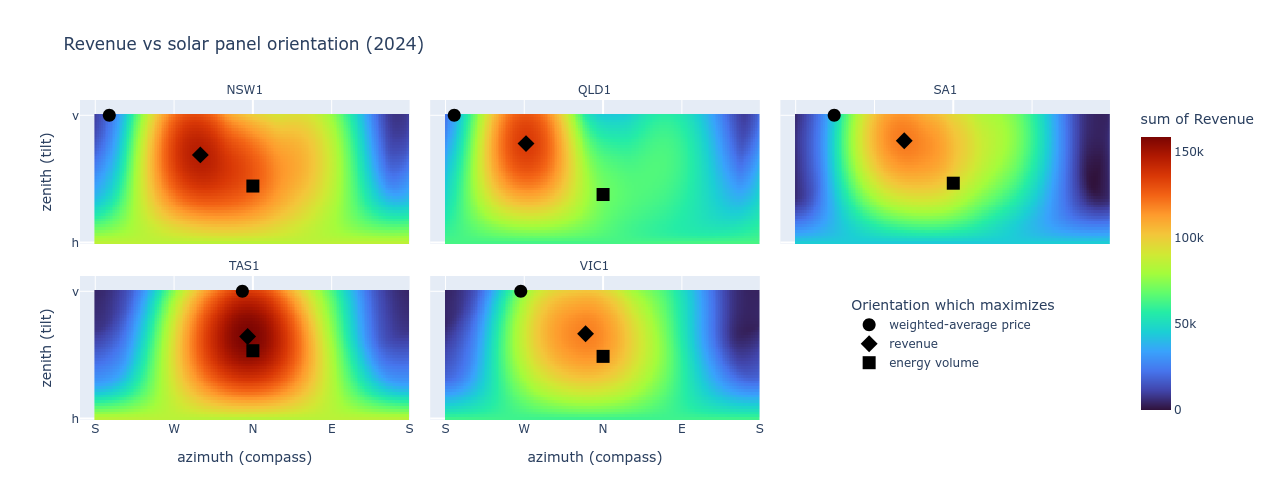

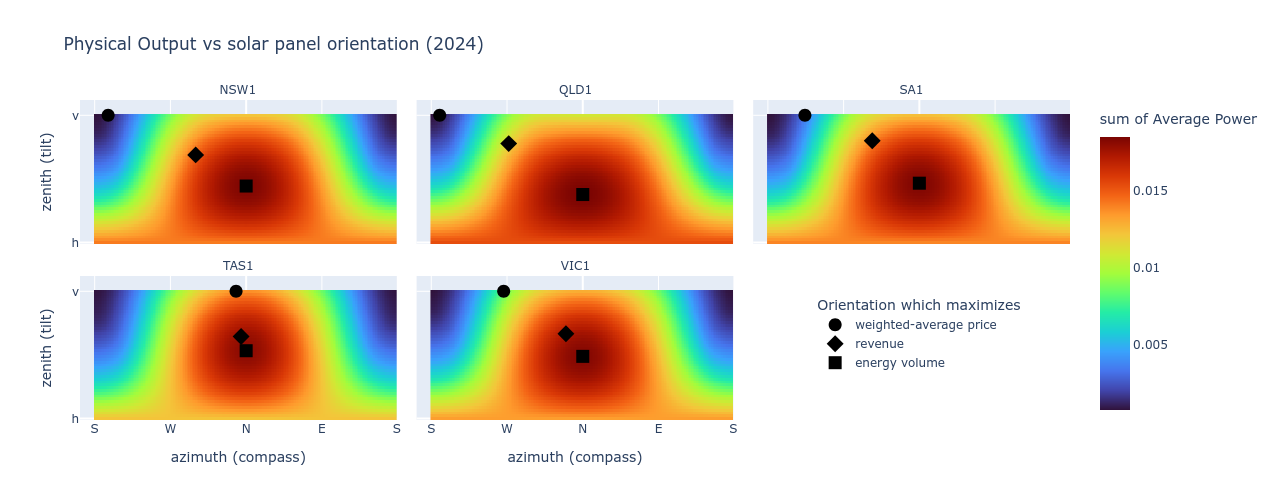

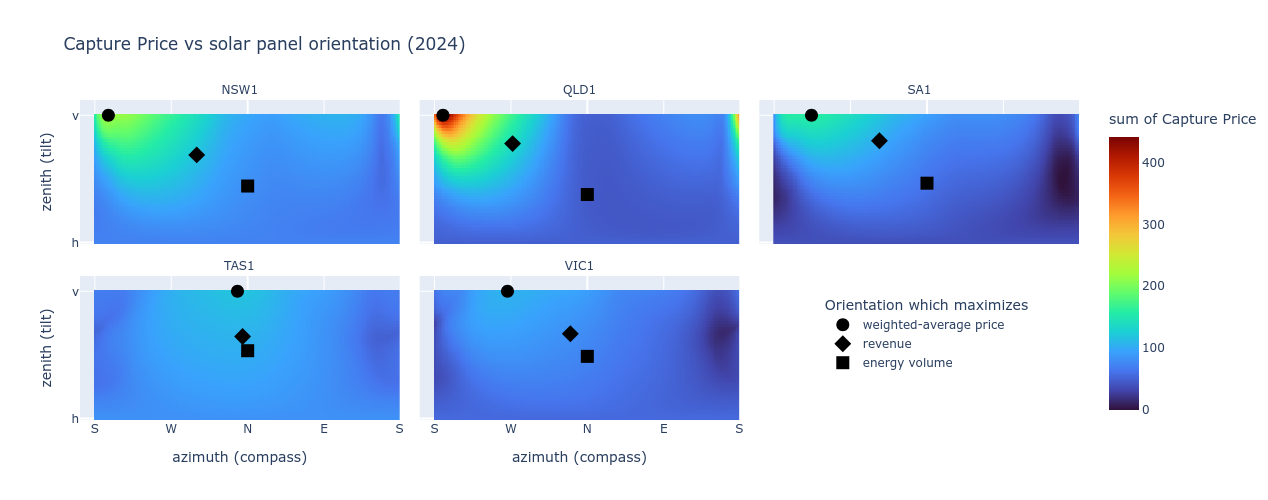

In [62]:
os.makedirs(results_dir, exist_ok=True)

plot_configs = [
    ("REVENUE", "Revenue", "$"),
    ("POWER_AVG", "Physical Output", "Average MW"),
    ("CAPTURE_PRICE", "Capture Price", "$/MWh"),
]

for (z, title, units) in plot_configs:
    
    fig = px.density_heatmap(heat_colours_df, 
                             x="PANEL_AZIMUTH", 
                             y="PANEL_ZENITH",
                             z=z,
                             title = f"{title} vs solar panel orientation (2024)",
                             histfunc="sum", # already one value per group
                             facet_col="REGIONID",
                             facet_col_wrap=3,
                             facet_row_spacing=0.1,
                             labels = {
                                 "PANEL_AZIMUTH": "azimuth (compass)",
                                 "PANEL_ZENITH": "zenith (tilt)",
                                 "REVENUE": "Revenue",
                                 "CAPTURE_PRICE": "Capture Price",
                                 "POWER_AVG": "Average Power",
                             },
                             hover_data=["YEAR", "REVENUE", "CAPTURE_PRICE", "POWER_AVG"],
                             color_continuous_scale="Turbo",
                            )
    
    fig.update_traces(xbins= {
                             'start': heat_colours_df.select(pl.col("PANEL_AZIMUTH").min()).item() - panel_azimuth_step/2,
                             'end': heat_colours_df.select(pl.col("PANEL_AZIMUTH").max()).item(),
                             'size': panel_azimuth_step
                         },
                         ybins = {
                             'start': heat_colours_df.select(pl.col("PANEL_ZENITH").min()).item() - panel_zenith_step / 2,
                             'end': heat_colours_df.select(pl.col("PANEL_ZENITH").max()).item(),
                             'size': panel_zenith_step
                         }
                        )

    # trace_fig = px.line(
    #     peaks_all_years.filter(pl.col("MAX_OF") == "REVENUE"),
    #     x="PANEL_AZIMUTH", 
    #     y="PANEL_ZENITH",
    #     text="YEAR_FIRST_LAST_TEXT",
    #     #size = "YEAR_RELATIVE",
    #     #color="YEAR",
    #     facet_col="REGIONID",
    #     hover_data=["YEAR", "REVENUE", "CAPTURE_PRICE", "POWER_AVG"],
    #     facet_col_wrap=3
    # )

        
    # # Add line traces to heatmap
    # for trace in trace_fig.data:
    #     fig.add_trace(trace)
    
    scatter_fig = px.scatter(peaks_last_year, 
                             x="PANEL_AZIMUTH", 
                             y="PANEL_ZENITH",
                             symbol="MAX_OF",
                             facet_col="REGIONID",
                             hover_data=["YEAR", "REVENUE", "CAPTURE_PRICE", "POWER_AVG"],
                             facet_col_wrap=3,
                             labels={
                                 "MAX_OF": "Maximum of what?"
                             }
                            )

    scatter_fig.update_traces(marker={'size': 13, 'color': 'black'})
    
    # Update legend labels
    scatter_fig.for_each_trace(
        lambda trace: trace.update(
            name={
                'CAPTURE_PRICE': 'weighted-average price',
                'REVENUE': 'revenue', 
                'POWER_AVG': 'energy volume'
            }.get(trace.name, trace.name)
        )
    )
    
    # Add scatter traces to heatmap
    for trace in scatter_fig.data:
        fig.add_trace(trace)
    
    fig.update_xaxes(
        tickmode='array',
        tickvals=[-180, -90, 0, 90, 180-1, 270],
        ticktext=['S', 'W', 'N', 'E', 'S', 'W']
    )
    
    fig.update_yaxes(
        tickmode='array',
        tickvals=[0, 90],
        ticktext=['h', 'v']
    )
    
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

    # manually reposition legends, otherwise they overlap
    fig.update_layout(
        # dots
        legend=dict(
            orientation="v",
            yanchor="top",
            y=0.4,
            xanchor="center",
            x=0.85,
            title="Orientation which maximizes ..."
        ),
        # heatmap
        legend2=dict(
            orientation="v", 
            yanchor="top",
            y=1,
            xanchor="left", 
            x=1.02,
        )
    )

    fig.update_layout(width=900, height=500)
    
    fig.show()

    fig.write_image(os.path.join(results_dir, f"{z}.png"))

In [41]:
improvement = (
    peaks_last_year
    .pivot("MAX_OF", values="REVENUE", index="REGIONID")
    .with_columns(
        (pl.col("REVENUE") / pl.col("POWER_AVG")).alias("IMPROVEMENT")
    )
    .sort("IMPROVEMENT")
)

improvement.write_parquet(os.path.join(results_dir, 'improvement.parquet'))
improvement.write_csv(os.path.join(results_dir, 'improvement.csv'))
improvement


REGIONID,CAPTURE_PRICE,REVENUE,POWER_AVG,IMPROVEMENT
str,f64,f64,f64,f64
"""TAS1""",135350.701347,158461.124918,155587.139331,1.018472
"""VIC1""",72699.258468,118668.025876,111489.037985,1.064392
"""NSW1""",21140.959668,145719.166694,126186.463659,1.154792
"""SA1""",45491.15644,119674.022092,95307.35291,1.255664
"""QLD1""",35403.472558,135195.453474,70462.640856,1.918683


## Compare to penetration

Plot angle between value and volume maximizing, vs % solar in the grid (including rooftop).

In [14]:
# find the angle between two vectors
angle_diff_history = (
    peaks_all_years
    .pivot("MAX_OF", index=["YEAR", "REGIONID"], values="PANEL")
    .rename({
        "REVENUE": "PANEL_MAX_REVENUE",
        "POWER_AVG": "PANEL_MAX_POWER",
        "CAPTURE_PRICE": "PANEL_MAX_CAPTURE_PRICE",
    })
    .with_columns(
        pl.col("PANEL_MAX_REVENUE").pipe(az_zen_to_xyz).alias("REVENUE_XYZ"),
        pl.col("PANEL_MAX_POWER").pipe(az_zen_to_xyz).alias("POWER_XYZ"),
    )
    .with_columns(
        pl.map_batches(
            ["REVENUE_XYZ", "POWER_XYZ"],
            lambda row: dot_product(row[0], row[1]),
            return_dtype=pl.Float64
        )
        .alias("COS_THETA")
    )
    .with_columns(
        pl.col("COS_THETA").arccos().degrees().alias("THETA")
    )
    .sort("YEAR", "REGIONID")
)
angle_diff_history

YEAR,REGIONID,PANEL_MAX_CAPTURE_PRICE,PANEL_MAX_POWER,PANEL_MAX_REVENUE,REVENUE_XYZ,POWER_XYZ,COS_THETA,THETA
i32,str,struct[2],struct[2],struct[2],struct[3],struct[3],f64,f64
2015,"""NSW1""","{198,78}","{0,32}","{348,30}","{0.489074,-0.103956,0.866025}","{0.529919,0.0,0.848048}",0.993601,6.485322
2015,"""QLD1""","{200,90}","{0,26}","{286,44}","{0.191474,-0.667748,0.71934}","{0.438371,0.0,0.898794}",0.730475,43.073777
2015,"""SA1""","{202,68}","{0,34}","{0,34}","{0.559193,0.0,0.829038}","{0.559193,0.0,0.829038}",1.0,0.0
2015,"""TAS1""","{182,68}","{0,40}","{4,32}","{0.528628,0.036965,0.848048}","{0.642788,0.0,0.766044}",0.989438,8.334644
2015,"""VIC1""","{198,68}","{0,36}","{358,34}","{0.558852,-0.019516,0.829038}","{0.587785,0.0,0.809017}",0.999191,2.305411
…,…,…,…,…,…,…,…,…
2024,"""NSW1""","{196,90}","{0,40}","{300,62}","{0.441474,-0.764655,0.469472}","{0.642788,0.0,0.766044}",0.64341,49.953435
2024,"""QLD1""","{190,90}","{0,34}","{272,70}","{0.032795,-0.93912,0.34202}","{0.559193,0.0,0.829038}",0.301886,72.429074
2024,"""SA1""","{224,90}","{0,42}","{304,72}","{0.531824,-0.788462,0.309017}","{0.669131,0.0,0.743145}",0.585504,54.161387


In [15]:
rooftop_pv_raw = (
    pl.scan_parquet(os.path.join(nemosis_dir, "*_ROOFTOP_PV_ACTUAL*.parquet"), low_memory=True)
    .with_columns(
        pl.col("INTERVAL_DATETIME").str.head(4).cast(pl.UInt16).alias("YEAR"),
        pl.col("INTERVAL_DATETIME", "LASTCHANGED").str.strptime(pl.Datetime("ms"), aemo_dt_fmt)
    )
    .filter(pl.col("INTERVAL_DATETIME").is_between(start_time, end_time))
)
rooftop_pv_raw.head().collect()

INTERVAL_DATETIME,REGIONID,POWER,QI,TYPE,LASTCHANGED,YEAR
datetime[ms],str,f64,f64,str,datetime[ms],u16
2016-08-01 00:30:00,"""NSW1""",0.0,1.0,"""DAILY""",2016-08-01 23:30:30,2016
2016-08-01 00:30:00,"""QLD1""",0.0,1.0,"""DAILY""",2016-08-01 23:30:30,2016
2016-08-01 00:30:00,"""SA1""",0.0,1.0,"""DAILY""",2016-08-01 23:30:30,2016
2016-08-01 00:30:00,"""TAS1""",0.0,1.0,"""DAILY""",2016-08-01 23:30:30,2016
2016-08-01 00:30:00,"""VIC1""",0.0,1.0,"""DAILY""",2016-08-01 23:30:30,2016


In [16]:
#rooftop_pv_deduplicated_pq = os.path.join(data_dir, f'rooftop_dedup_{start_time.strftime(file_dt_fmt)}_to_{end_time.strftime(file_dt_fmt)}.parquet')

rooftop_pv = (
    rooftop_pv_raw
    .filter(pl.col("INTERVAL_DATETIME").is_between(start_time, end_time))
    .filter(pl.col("REGIONID").cast(str).str.ends_with("1")) # delete sub-regions
    # deduplicate
    .sort(by=["TYPE", "QI", "LASTCHANGED"], descending=[False, True, True])
    .group_by(["REGIONID", "YEAR", "INTERVAL_DATETIME"])
    .first()
    .select(["REGIONID", "YEAR", "INTERVAL_DATETIME", "POWER"])
    .rename({
        "INTERVAL_DATETIME": "INTERVAL_END",
        "POWER": "POWER_MW",
    })
    .with_columns(
        # convert power to energy, for half hour readings
        (pl.col("POWER_MW") / 2).alias("ENERGY_MWH")
    )
    .with_columns(pl.col("INTERVAL_END").dt.cast_time_unit("ms"))
    .with_columns([pl.col("INTERVAL_END").dt.offset_by("-30m").alias("INTERVAL_START")])
    .filter(pl.col("REGIONID").is_not_null()) # bug with polars adds null rows
)


In [17]:
yearly_rooftop_df = (
    rooftop_pv
    .group_by("YEAR")
    .agg(pl.col("ENERGY_MWH").sum())
    .collect()
)

yearly_rooftop_df.head()

YEAR,ENERGY_MWH
u16,f64
2022,1.8707e7
2023,2.3148e7
2017,6.7929e6
2016,2.8952e6
2020,1.3043e7


In [18]:
dispatchscada = (
    pl.scan_parquet(os.path.join(nemosis_dir, "*_DISPATCH_UNIT_SCADA*.parquet"), low_memory=True)
    # .with_columns(
    #     pl.col("SETTLEMENTDATE").str.head(4).cast(pl.UInt16).alias("YEAR")
    # )
    # .with_columns(
    #     pl.col("SETTLEMENTDATE").str.strptime(pl.Datetime("ms"), aemo_dt_fmt)
    # )
    # .filter(pl.col("SETTLEMENTDATE").is_between(start_time, end_time))
    # .rename({
    #     "SETTLEMENTDATE": "INTERVAL_END"
    # })
    # .with_columns(
    #     pl.col("INTERVAL_END").dt.offset_by("-5m").alias("INTERVAL_START")
    # )
    .with_columns(
        pl.col("SETTLEMENTDATE").str.head(4).cast(pl.UInt16).alias("YEAR")
    )
)
dispatchscada.head().collect()

SETTLEMENTDATE,DUID,SCADAVALUE,YEAR
str,str,f64,u16
"""2015/01/01 00:05:00""","""ANGAS1""",0.0,2015
"""2015/01/01 00:05:00""","""ANGAS2""",0.0,2015
"""2015/01/01 00:05:00""","""BUTLERSG""",9.699999,2015
"""2015/01/01 00:05:00""","""CALL_A_4""",24.01,2015
"""2015/01/01 00:05:00""","""CAPTL_WF""",0.0,2015


In [19]:
static_pd = static_table('Generators and Scheduled Loads', nemosis_dir)
static_pd

INFO: Retrieving static table Generators and Scheduled Loads


,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,DUID
0,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Bidirectional Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,ADPBA1
1,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,ADPBA1G
2,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Load,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,ADPBA1L
3,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Non-Scheduled,Hydro,Water,Renewable,Run of River,Y,ADPMH1
4,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,Y,ADPPV1
...,...,...,...,...,...,...,...,...,...,...,...,...
536,AGL Hydro Partnership,Yarrawonga Hydro Power Station,VIC1,Generating Unit,Market,Non-Scheduled,Hydro,Water,Renewable,Hydro - Gravity,N,YWNGAHYD
537,RTA Yarwun Pty Ltd,Yarwun Power Station,QLD1,Generating Unit,Market,Non-Scheduled**,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,YARWUN_1
538,Yatpool Sun Farm Pty Ltd,Yatpool Solar Farm,VIC1,Generating Unit,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,Y,YATSF1
539,Alinta Energy Retail Sales Pty Ltd,Yawong Wind Farm,VIC1,Generating Unit,Market,Non-Scheduled,Wind,Wind,Renewable,Wind - Onshore,Y,YAWWF1


In [20]:
static = (
    pl.from_pandas(static_pd)
    .with_columns(
        (pl.col("Fuel Source - Primary") == "Solar").alias("IS_SOLAR"),
    )
    # remove loads and storage
    .filter(pl.col("Dispatch Type") == "Generating Unit")
    .filter(pl.col("Technology Type - Primary") != "Storage")
    .lazy()
)

In [21]:
# sink to parquet file, then read back
# because otherwise we run out of memory
dispatchscada_processed_pq = os.path.join(data_dir, "dispatchscada_years.parquet")
(
    dispatchscada
    .with_columns(
        (pl.col("SCADAVALUE") / intervals_per_h).alias("ENERGY_MWH")
    )
    .join(static, on="DUID", how="inner")
    .select(
        pl.col("Region").alias("REGIONID"),
        "YEAR",
        "ENERGY_MWH",
        "IS_SOLAR",
    )
    .sink_parquet(dispatchscada_processed_pq)
)

In [22]:
regionid_enum = pl.Enum(["QLD1", "NSW1", "VIC1", "SA1", "TAS1"])
regionid_enum

Enum(categories=['QLD1', 'NSW1', 'VIC1', 'SA1', 'TAS1'])

In [23]:
solar_frac_history = (
    pl.concat([
        pl.scan_parquet(dispatchscada_processed_pq, low_memory=True),
        rooftop_pv
        .with_columns(pl.lit(True).alias("IS_SOLAR"))
    ], how='diagonal_relaxed')
    .cast({"REGIONID": regionid_enum})
    .group_by("YEAR", "REGIONID")
    .agg(
        (pl.col("ENERGY_MWH").filter(pl.col("IS_SOLAR")).sum() / pl.col("ENERGY_MWH").sum()).alias("FRAC_SOLAR")
    )
    .sort("REGIONID", "YEAR")
    .collect()
)
solar_frac_history

YEAR,REGIONID,FRAC_SOLAR
u16,enum,f64
2015,"""QLD1""",0.0
2016,"""QLD1""",0.017921
2017,"""QLD1""",0.041383
2018,"""QLD1""",0.05867
2019,"""QLD1""",0.098962
…,…,…
2020,"""TAS1""",0.018817
2021,"""TAS1""",0.020813
2022,"""TAS1""",0.024067


In [29]:
angle_vs_pv_frac = (
    angle_diff_history.cast({"REGIONID": regionid_enum})
    .join(solar_frac_history, on=["YEAR", "REGIONID"], how='inner')
    .join(peaks_all_years.cast({"REGIONID": regionid_enum}), on=["YEAR", "REGIONID"], how='inner')
    .sort("REGIONID", "YEAR")
)
angle_vs_pv_frac

YEAR,REGIONID,PANEL_MAX_CAPTURE_PRICE,PANEL_MAX_POWER,PANEL_MAX_REVENUE,REVENUE_XYZ,POWER_XYZ,COS_THETA,THETA,FRAC_SOLAR,PANEL,PANEL_AZIMUTH,PANEL_ZENITH,MAX_OF,POWER_AVG,CAPTURE_PRICE,REVENUE,YEAR_FIRST_LAST_TEXT,YEAR_RELATIVE
i32,enum,struct[2],struct[2],struct[2],struct[3],struct[3],f64,f64,f64,struct[2],i32,i32,str,f64,f64,f64,str,i32
2015,"""QLD1""","{200,90}","{0,26}","{286,44}","{0.191474,-0.667748,0.71934}","{0.438371,0.0,0.898794}",0.730475,43.073777,0.0,"{286,44}",-74,44,"""REVENUE""",0.02733,73.31656,168316.489532,"""2015""",1
2015,"""QLD1""","{200,90}","{0,26}","{286,44}","{0.191474,-0.667748,0.71934}","{0.438371,0.0,0.898794}",0.730475,43.073777,0.0,"{0,26}",0,26,"""POWER_AVG""",0.031698,52.731298,140402.874464,"""2015""",1
2015,"""QLD1""","{200,90}","{0,26}","{286,44}","{0.191474,-0.667748,0.71934}","{0.438371,0.0,0.898794}",0.730475,43.073777,0.0,"{200,90}",-160,90,"""CAPTURE_PRICE""",0.00347,146.870758,42815.628039,"""2015""",1
2016,"""QLD1""","{202,88}","{0,28}","{324,30}","{0.404508,-0.293893,0.866025}","{0.469472,0.0,0.882948}",0.95456,17.338592,0.017921,"{324,30}",-36,30,"""REVENUE""",0.032917,74.022336,204675.017618,null,2
2016,"""QLD1""","{202,88}","{0,28}","{324,30}","{0.404508,-0.293893,0.866025}","{0.469472,0.0,0.882948}",0.95456,17.338592,0.017921,"{0,28}",0,28,"""POWER_AVG""",0.033674,71.289745,201653.260253,null,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2023,"""TAS1""","{180,90}","{0,40}","{358,40}","{0.642396,-0.022433,0.766044}","{0.642788,0.0,0.766044}",0.999748,1.285537,0.032003,"{0,40}",0,40,"""POWER_AVG""",0.031295,41.97748,110349.9534,null,9
2023,"""TAS1""","{180,90}","{0,40}","{358,40}","{0.642396,-0.022433,0.766044}","{0.642788,0.0,0.766044}",0.999748,1.285537,0.032003,"{358,40}",-2,40,"""REVENUE""",0.031291,41.983599,110351.981365,null,9
2024,"""TAS1""","{348,90}","{0,48}","{354,58}","{0.843402,-0.088645,0.529919}","{0.743145,0.0,0.669131}",0.981355,11.081335,0.036846,"{0,48}",0,48,"""POWER_AVG""",0.018085,102.416841,155587.139331,"""2024""",10


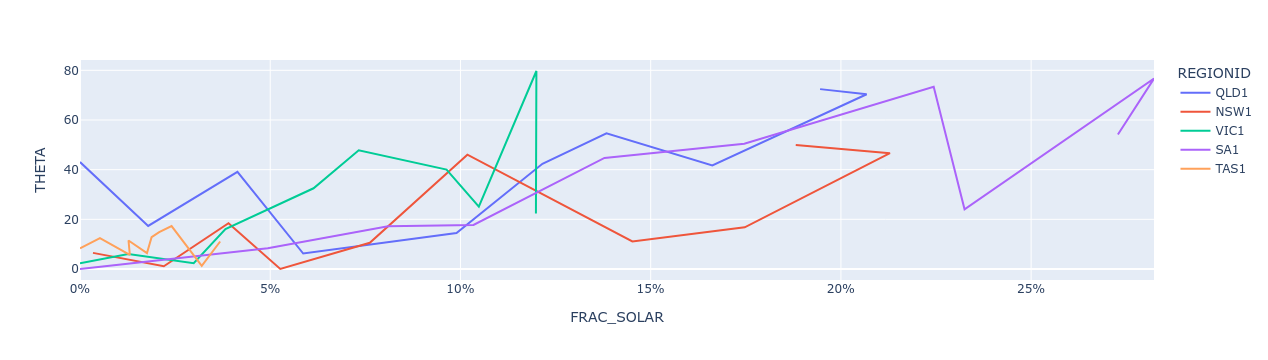

In [40]:
fig = px.line(
    angle_vs_pv_frac,
    x="FRAC_SOLAR",
    y="THETA",
    color="REGIONID",
    hover_data=["YEAR", "REVENUE", "CAPTURE_PRICE", "POWER_AVG"],
    #facet_col_wrap=3
)

fig.update_layout(xaxis_tickformat = '.0%')

fig.show()
fig.write_image(os.path.join(results_dir, f"theta_vs_frac_solar.png"))

In [66]:
(
    solar_frac_history
    .cast({"REGIONID": str})
    .filter(pl.col("YEAR") == pl.col("YEAR").max())
    .join(improvement, on=["REGIONID"])
    .sort("IMPROVEMENT")
)

YEAR,REGIONID,FRAC_SOLAR,CAPTURE_PRICE,REVENUE,POWER_AVG,IMPROVEMENT
u16,str,f64,f64,f64,f64,f64
2024,"""TAS1""",0.036846,135350.701347,158461.124918,155587.139331,1.018472
2024,"""VIC1""",0.119834,72699.258468,118668.025876,111489.037985,1.064392
2024,"""NSW1""",0.188129,21140.959668,145719.166694,126186.463659,1.154792
2024,"""SA1""",0.272808,45491.15644,119674.022092,95307.35291,1.255664
2024,"""QLD1""",0.19453,35403.472558,135195.453474,70462.640856,1.918683
